---------- Similarity metrics ----------
Alameda County: 8,760 hourly points
  Mean absolute diff :     0.34 kWh
  RMSE               :     0.53 kWh
  Pearson correlation:    0.616
----------------------------------------



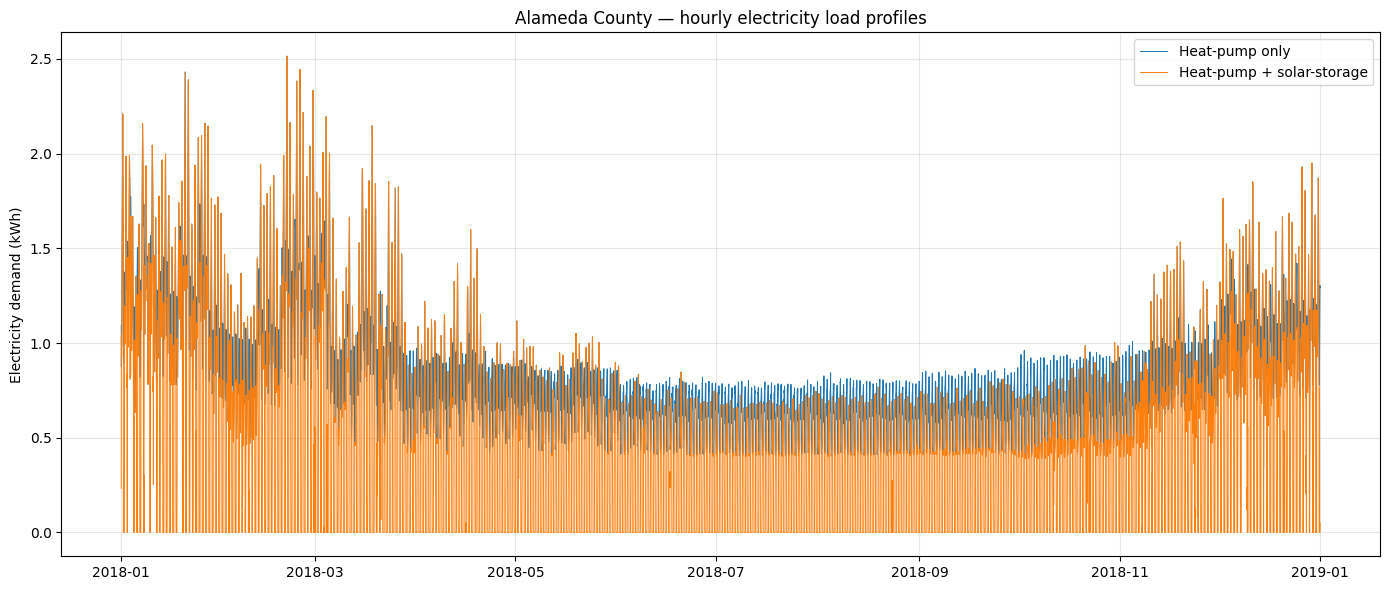

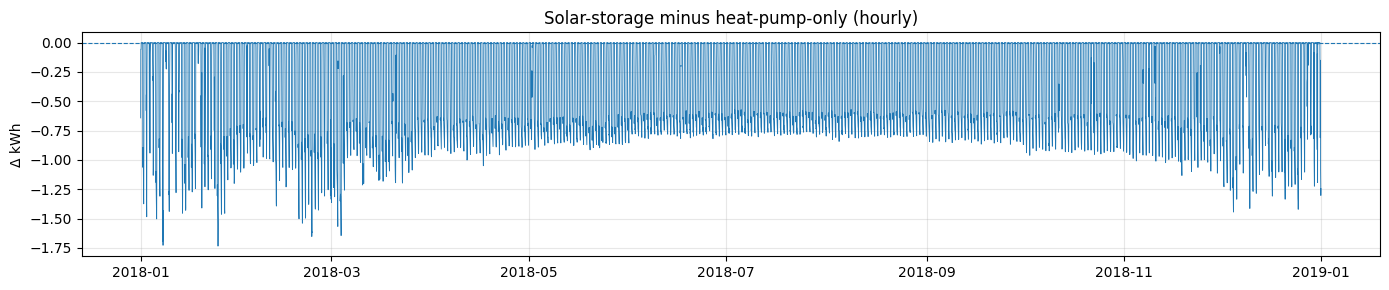

{'MAE': 0.34267266633569676,
 'RMSE': 0.5270337601090124,
 'corr': 0.6163020974023202}

In [4]:
"""
compare_heat_pump_profiles.py

Compare and visualise hourly electricity-load profiles for
    • heat-pump electrification only   (“default.electricity.kwh”)
    • heat-pump + solar + storage      (“solarstorage.electricity.kwh”)

The script prints simple similarity metrics and produces two plots:
    1. The two load traces over time
    2. The hourly difference (solar-storage minus default)

Author: <you>
"""

import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


# ---------------------------------------------------------------------------
# Utility helpers -----------------------------------------------------------
# ---------------------------------------------------------------------------
def slugify_county_name(name: str) -> str:
    """Fallback slugifier (mirrors helpers.slugify_county_name)."""
    return (
        name.lower()
        .replace("county", "")        # optional: strip the word “County”
        .replace("&", "and")
        .replace(",", "")
        .replace("-", " ")
        .strip()
        .replace(" ", "_")
    )


def get_rates_csv(base_output_dir: str | Path,
                  housing_type: str,
                  county: str,
                  scenario: str = "heat_pump",
                  filename_root: str = "loadprofiles_for_rates") -> Path:
    """Return the path to the *_rates_…csv produced by step 9."""
    county_slug = slugify_county_name(county)
    return (
        Path(base_output_dir)
        / scenario / housing_type / county_slug
        / f"{filename_root}_{county_slug}.csv"
    )


# ---------------------------------------------------------------------------
# Core comparison function --------------------------------------------------
# ---------------------------------------------------------------------------
def compare_heat_pump_profiles(base_output_dir: str | Path,
                               housing_type: str,
                               county: str,
                               show: bool = True,
                               savefig: bool = False):
    """
    Load the ‘heat_pump’ scenario CSV for *county* and plot / quantify the
    difference between:
        • default.electricity.kwh
        • solarstorage.electricity.kwh
    """
    # ----------------------------------------------------------------------
    # 1) Read the hourly data
    # ----------------------------------------------------------------------
    csv_path = get_rates_csv(base_output_dir, housing_type, county)
    if not csv_path.exists():
        raise FileNotFoundError(f"Rates-file not found: {csv_path}")

    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    cols = ["default.electricity.kwh", "solarstorage.electricity.kwh"]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(
            f"Expected columns {missing} not present in {csv_path.name}"
        )

    # ----------------------------------------------------------------------
    # 2) Quick similarity diagnostics
    # ----------------------------------------------------------------------
    df["diff.kwh"] = df[cols[1]] - df[cols[0]]
    mae  = df["diff.kwh"].abs().mean()                     # mean abs. error
    rmse = (df["diff.kwh"] ** 2).mean() ** 0.5             # root-MSE
    corr = df[cols].corr().iloc[0, 1]                      # Pearson r

    print("---------- Similarity metrics ----------")
    print(f"{county}: {len(df):,} hourly points")
    print(f"  Mean absolute diff : {mae:8.2f} kWh")
    print(f"  RMSE               : {rmse:8.2f} kWh")
    print(f"  Pearson correlation: {corr:8.3f}")
    print("----------------------------------------\n")

    # ----------------------------------------------------------------------
    # 3) Plots
    # ----------------------------------------------------------------------
    if show or savefig:
        # (a) Time-series traces
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(df["timestamp"], df[cols[0]],
                label="Heat-pump only", linewidth=0.7)
        ax.plot(df["timestamp"], df[cols[1]],
                label="Heat-pump + solar-storage", linewidth=0.7)
        ax.set_ylabel("Electricity demand (kWh)")
        ax.set_title(f"{county} — hourly electricity load profiles")
        ax.legend()
        ax.grid(alpha=0.3)
        plt.tight_layout()

        # (b) Hourly difference
        fig2, ax2 = plt.subplots(figsize=(14, 3))
        ax2.plot(df["timestamp"], df["diff.kwh"], linewidth=0.6)
        ax2.axhline(0, linestyle="--", linewidth=0.8)
        ax2.set_ylabel("Δ kWh")
        ax2.set_title("Solar-storage minus heat-pump-only (hourly)")
        ax2.grid(alpha=0.3)
        plt.tight_layout()

        if savefig:
            county_slug = slugify_county_name(county)
            out_dir = csv_path.parent
            fig.savefig(out_dir / f"profile_comparison_{county_slug}.png",
                        dpi=150)
            fig2.savefig(out_dir / f"profile_difference_{county_slug}.png",
                         dpi=150)
            print(f"Plots saved to {out_dir}")

        if show:
            plt.show()

    # ----------------------------------------------------------------------
    return {"MAE": mae, "RMSE": rmse, "corr": corr}


# ---------------------------------------------------------------------------
# Example usage -------------------------------------------------------------
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
BASE_OUT   = "../data/loadprofiles"                     # where step 9 wrote its CSVs
HOUSING    = "single-family-detached"
COUNTY     = "Alameda County"

compare_heat_pump_profiles(
    base_output_dir=BASE_OUT,
    housing_type=HOUSING,
    county=COUNTY,
    show=True,          # pop up the plots
    savefig=False       # flip to True to write *.png files next to the CSV
)

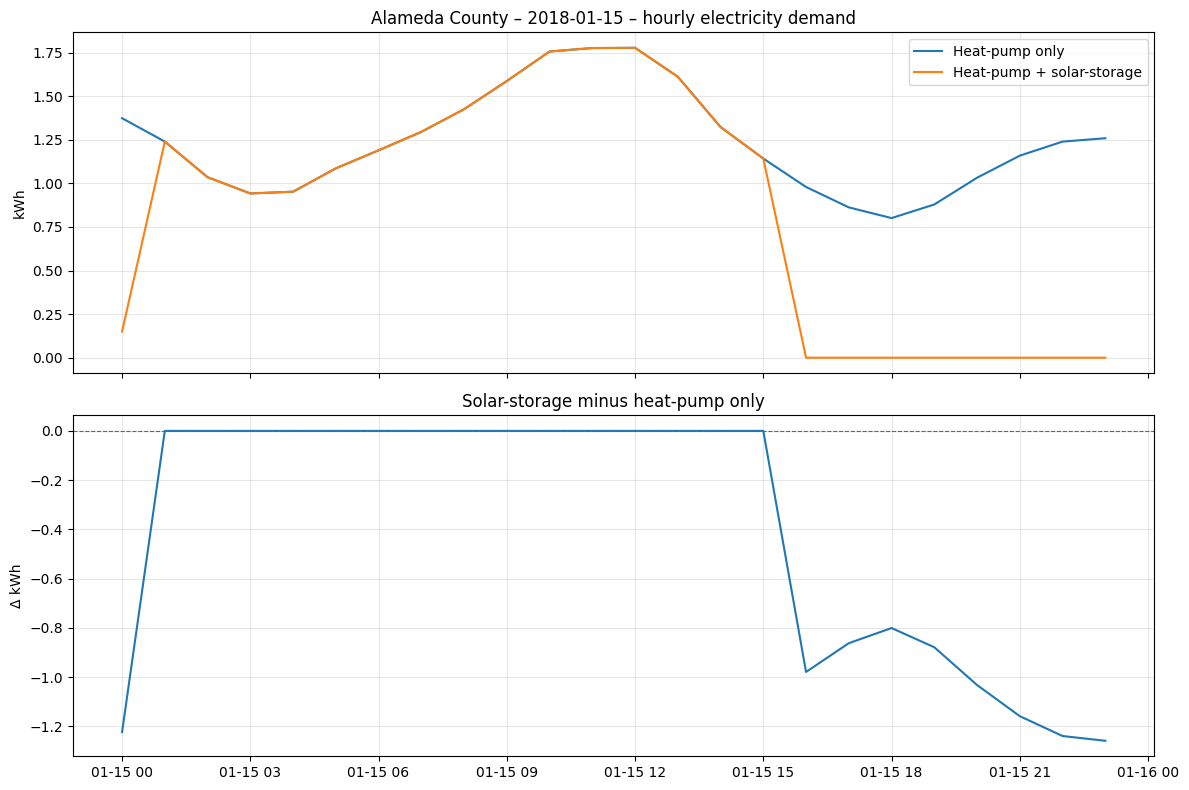

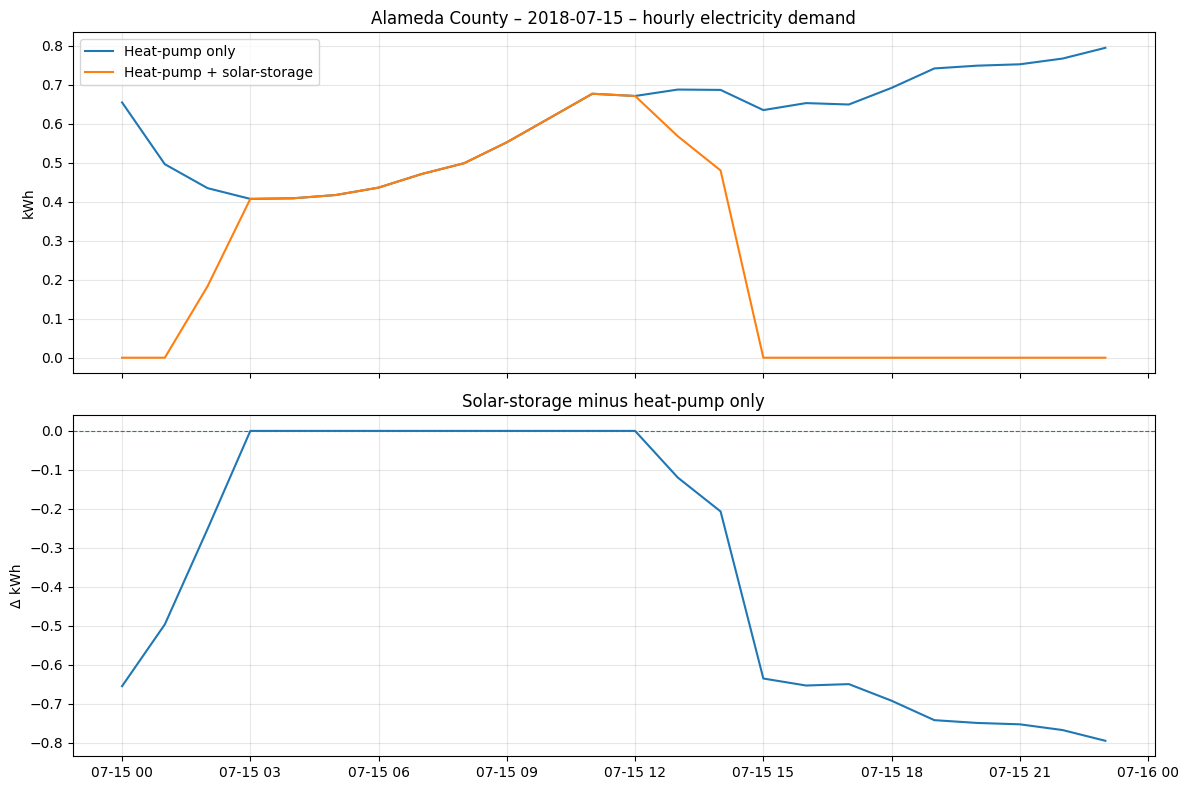

In [8]:
# ---------------------------------------------------------------------------
# Quick visual check of ONE winter day + ONE summer day
# ---------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

def plot_single_day(df: pd.DataFrame,
                    day: str | datetime,
                    title_prefix: str = "",
                    show_diff: bool = False):
    """
    Plot the two series for a single calendar day.

    Parameters
    ----------
    df : DataFrame
        Must contain:
          • 'timestamp' (datetime),
          • 'default.electricity.kwh',
          • 'solarstorage.electricity.kwh'
    day : str or datetime
        e.g. "2018-01-15" (mid-winter) or datetime(2018, 7, 15)
    title_prefix : str
        Added in front of automatic title e.g. county name
    show_diff : bool, default False
        If True, add a 2nd subplot with hourly difference.
    """
    # ----------------------------------------------------------------------
    # 1) Slice the chosen day
    # ----------------------------------------------------------------------
    day = pd.to_datetime(day).normalize()          # floor to 00:00
    next_day = day + timedelta(days=1)
    mask = (df["timestamp"] >= day) & (df["timestamp"] < next_day)
    day_df = df.loc[mask]

    if day_df.empty:
        raise ValueError(f"No data found for {day.date()}")

    # ----------------------------------------------------------------------
    # 2) Plot
    # ----------------------------------------------------------------------
    n_rows = 2 if show_diff else 1
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 4 * n_rows), sharex=True)

    # --- NEW, ROBUST WAY ---------------------------------------------------
    # Ensure `axes` is always a 1-D iterable of Axes objects
    axes = np.atleast_1d(axes)
    # ----------------------------------------------------------------------

    ax = axes[0]

    ax = axes[0]
    ax.plot(day_df["timestamp"], day_df["default.electricity.kwh"],
            label="Heat-pump only")
    ax.plot(day_df["timestamp"], day_df["solarstorage.electricity.kwh"],
            label="Heat-pump + solar-storage")
    ax.set_ylabel("kWh")
    ax.set_title(f"{title_prefix}{day.date()} – hourly electricity demand")
    ax.legend()
    ax.grid(alpha=0.3)

    if show_diff:
        ax2 = axes[1]
        ax2.plot(day_df["timestamp"],
                 day_df["solarstorage.electricity.kwh"]
                 - day_df["default.electricity.kwh"])
        ax2.axhline(0, linestyle="--", linewidth=0.8)
        ax2.set_ylabel("Δ kWh")
        ax2.set_title("Solar-storage minus heat-pump only")
        ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------------
# Example: Alameda County – 15 Jan and 15 Jul
# ---------------------------------------------------------------------------
BASE_OUT   = "../data/loadprofiles"                     # where step-9 CSVs live
HOUSING    = "single-family-detached"
COUNTY     = "Alameda County"

# 1) read the already-aggregated CSV
csv_path = get_rates_csv(BASE_OUT, HOUSING, COUNTY,
                         scenario="heat_pump")      # <- keep scenario fixed
df = pd.read_csv(csv_path, parse_dates=["timestamp"])

# 2) pick sample days (feel free to change)
winter_day = "2018-01-15"
summer_day = "2018-07-15"

# 3) plot them
plot_single_day(df, winter_day,
                title_prefix=f"{COUNTY} – ",
                show_diff=True)

plot_single_day(df, summer_day,
                title_prefix=f"{COUNTY} – ",
                show_diff=True)